In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
!pip install Livelossplot
from livelossplot import PlotLossesKeras


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mias-mammography/Info.txt
/kaggle/input/mias-mammography/all_mias_scans.h5
/kaggle/input/mias-mammography/all-mias.tar.gz
/kaggle/input/mias-mammography/all-mias/mdb152.pgm
/kaggle/input/mias-mammography/all-mias/mdb088.pgm
/kaggle/input/mias-mammography/all-mias/mdb113.pgm
/kaggle/input/mias-mammography/all-mias/mdb182.pgm
/kaggle/input/mias-mammography/all-mias/mdb239.pgm
/kaggle/input/mias-mammography/all-mias/mdb066.pgm
/kaggle/input/mias-mammography/all-mias/mdb220.pgm
/kaggle/input/mias-mammography/all-mias/mdb292.pgm
/kaggle/input/mias-mammography/all-mias/mdb286.pgm
/kaggle/input/mias-mammography/all-mias/mdb103.pgm
/kaggle/input/mias-mammography/all-mias/mdb194.pgm
/kaggle/input/mias-mammography/all-mias/mdb275.pgm
/kaggle/input/mias-mammography/all-mias/mdb060.pgm
/kaggle/input/mias-mammography/all-mias/mdb067.pgm
/kaggle/input/mias-mammography/all-mias/mdb023.pgm
/kaggle/input/mias-mammography/all-mias/mdb073.pgm
/kaggle/input/mias-mammography/all-mias/mdb307.p

     |████████████████████████████████| 428 kB 436 kB/s eta 0:00:01
  Attempting uninstall: tornado
    Found existing installation: tornado 5.0.2
    Uninstalling tornado-5.0.2:
      Successfully uninstalled tornado-5.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab-git 0.11.0 requires nbdime<2.0.0,>=1.1.0, but you have nbdime 2.1.0 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# AIM
## To classify the images into 
### F Fatty
### G Fatty-glandular
### D Dense-glandular

# Validation Strategy:

## Train Data Size= 0.7*Total_Data
## Validation Data Size= 0.21* Total_Data
## Test Data Size= 0.09 * Total_Data

# Augmentaions Used:
## Each Image is rotated through 45 angles


In [2]:

import numpy as np
import pandas as pd
import cv2
from PIL import Image
import scipy

import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
# import pydot

from sklearn.metrics import *
from sklearn.model_selection import *
import tensorflow.keras.backend as K

from tqdm import tqdm, tqdm_notebook
from colorama import Fore
import json
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import time
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import lightgbm as lgb
import xgboost as xgb

print("All modules have been imported")

All modules have been imported


In [3]:
info=pd.read_csv("../input/mias-mammography/Info.txt",sep=" ")
info=info.drop('Unnamed: 7',axis=1)
info.SEVERITY.fillna(0)

0      B
1      B
2      0
3      0
4      B
      ..
325    0
326    0
327    0
328    0
329    0
Name: SEVERITY, Length: 330, dtype: object

In [4]:
info.BG.value_counts()

D    117
F    109
G    104
Name: BG, dtype: int64

<AxesSubplot:ylabel='CLASS'>

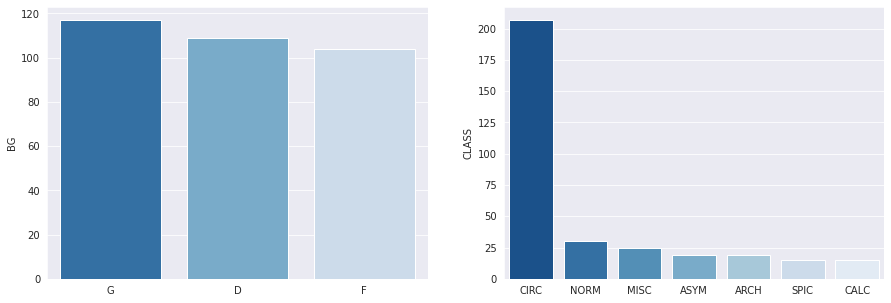

In [5]:
sns.set_style('darkgrid')
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,5))
sns.barplot(x=info.BG.unique(),y=info.BG.value_counts(),palette='Blues_r',ax=ax1)
sns.barplot(x=info.CLASS.unique(),y=info.CLASS.value_counts(),palette='Blues_r',ax=ax2)


# Visualizing the Images

In [6]:
from PIL import Image
import glob
x= []
for filename in sorted(glob.glob("../input/mias-mammography/all-mias/*.pgm")): 
    img=cv2.imread(filename)
    img =cv2.resize(img,(224, 224))
    x.append(img)


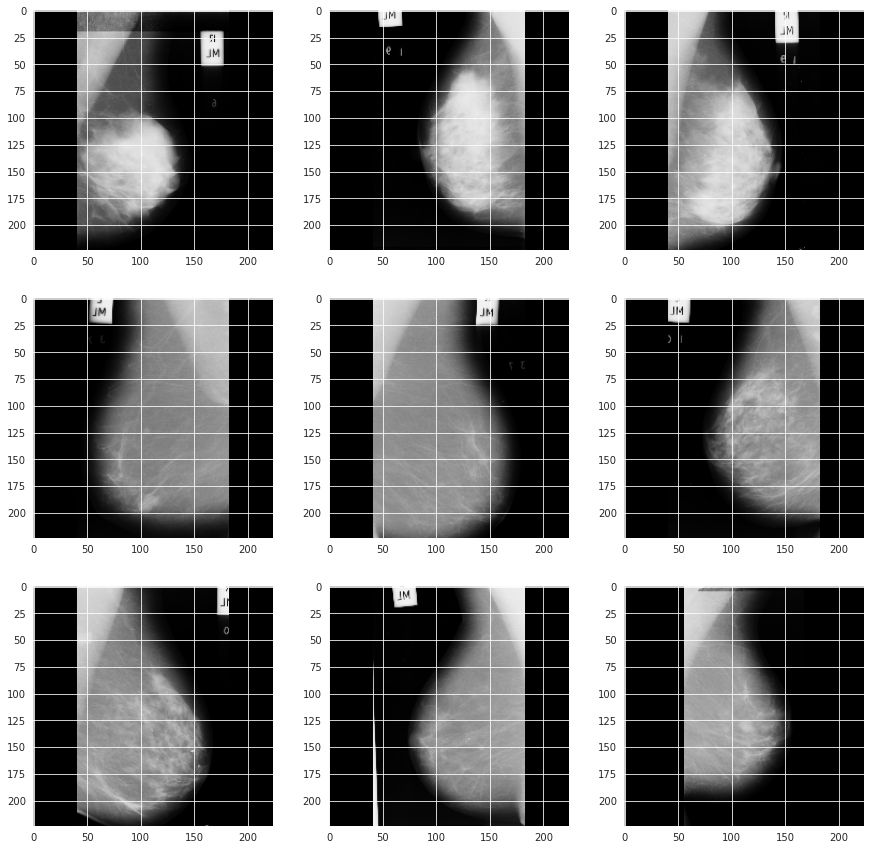

In [7]:
fig=plt.figure(figsize=(15,15))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = np.random.randint(10)
    fig.add_subplot(rows, columns, i)
    plt.imshow(x[i])
plt.show()

In [8]:
# Image Augmentation
no_angles = 360
url = '/kaggle/input/mias-mammography/all-mias/'

def save_dictionary(path,data):
        print('saving catalog...')
        #open('u.item', encoding="utf-8")
        import json
        with open(path,'w') as outfile:
            json.dump(str(data), fp=outfile)
        # save to file:
        print(' catalog saved')

In [9]:
# train_test_split_datagen=ImageDataGenerator("augmentations such as flip,brightness range,etc....")
# val_datagen=ImageDataGenerator("augmentations such as flip,brightness range,etc....")
# test_datagen=ImageDataGenerator("augmentations such as flip,brightness range,etc....")
def read_image():
        print("Reading images")
        import cv2
        info = {}
        for i in range(322):
            if i<9:
                image_name='mdb00'+str(i+1)
            elif i<99:
                image_name='mdb0'+str(i+1)
            else:
                image_name = 'mdb' + str(i+1)
            image_address= url+image_name+'.pgm'
            img = cv2.imread(image_address,1)
            img = cv2.resize(img, (224,224))
            rows, cols,channel = img.shape
            info[image_name]={}
            for angle in range(0,no_angles,8):
                M = cv2.getRotationMatrix2D((cols / 2, rows / 2), angle, 1) 
                img_rotated = cv2.warpAffine(img, M, (cols, rows))
                info[image_name][angle]=img_rotated
        return (info)


In [10]:
import os #Operating System
import sys #System
# train_generator = train_datagen.flow(x_train, y_train, batch_size =)
# val_generator = val_datagen.flow(x_val, y_val, batch_size = 64)
# test_generator=test_datagen.flow(x_test,y_test,batch_size = 64)

def get_script_path():
    return os.path.dirname(os.path.realpath(sys.argv[0]))    

def read_lable():
    filename = url+'Info.txt'
    text_all = open(filename).read()
    #print(text_all)
    lines=text_all.split('\n')
    info={}
    for line in lines:
        words=line.split(' ')
        if len(words)>1:
            if (words[1] == 'G'):
                info[words[0]] = {}
                for angle in range(no_angles):
                    info[words[0]][angle] = 2
            if (words[1] == 'D'):
                info[words[0]] = {}
                for  angle in range(no_angles):
                    info[words[0]][angle] = 1
            if (words[1] == 'F'):
                info[words[0]] = {}
                for  angle in range(no_angles):
                    info[words[0]][angle] = 0
            
    return (info)

In [11]:
import numpy as np
lable_info=read_lable()
image_info=read_image()
ids=lable_info.keys() 
#del lable_info['Truth-Data:']
X=[]
Y=[]
for id in ids:
    for angle in range(0,no_angles,8):
        X.append(image_info[id][angle])
        Y.append(lable_info[id][angle])
X=np.array(X)
Y=np.array(Y)
Y=to_categorical(Y,3)
x_train, x_test1, y_train, y_test1 = train_test_split(X, Y, test_size=0.3, random_state=42)
x_val, x_test, y_val, y_test = train_test_split(x_test1, y_test1, test_size=0.3, random_state=42)
print(len(x_train),len(x_val),len(x_test))

Reading images
10143 3042 1305


In [12]:
Y1=pd.DataFrame(Y)
Y1.value_counts()

0    1    2  
0.0  1.0  0.0    5040
1.0  0.0  0.0    4770
0.0  0.0  1.0    4680
dtype: int64

# Defining our callbacks

In [13]:
#Callbacks
c2=tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=6,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

c3=tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=6,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.001
)
nClasses=3

# 2 Layered CNN


In [14]:
model = Sequential()

model.add(Conv2D(16,(3,3),padding='same',input_shape =x_train[0].shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model.add(Conv2D(32,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model.add(Flatten())
model.add(Dense(nClasses,activation='softmax'))
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 16)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0

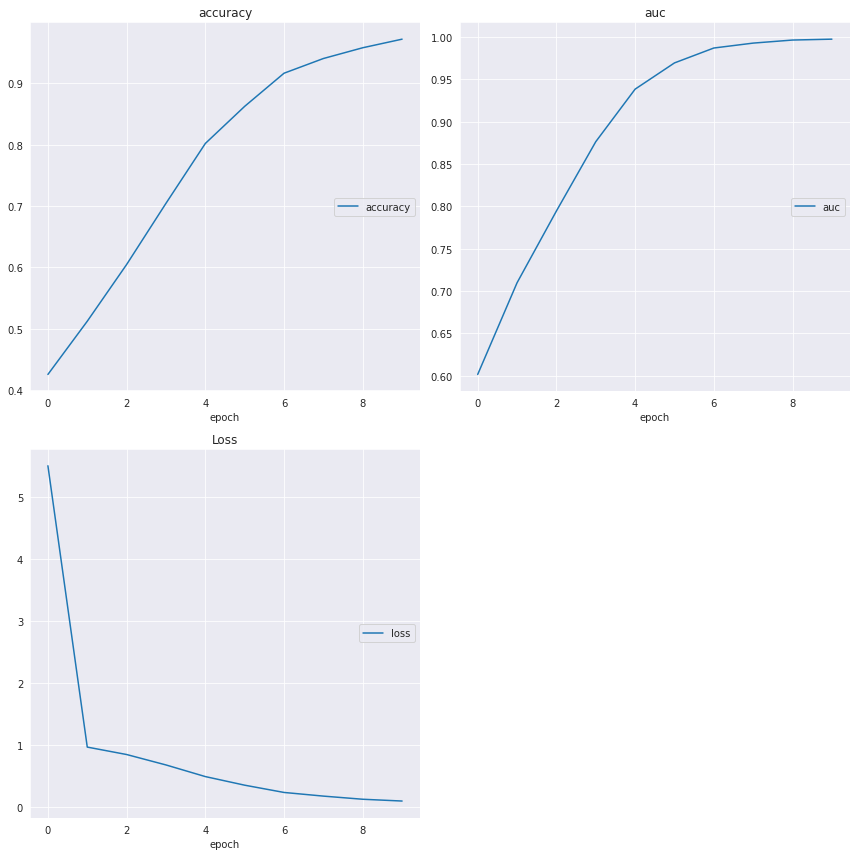

accuracy
	accuracy         	 (min:    0.426, max:    0.972, cur:    0.972)
auc
	auc              	 (min:    0.602, max:    0.998, cur:    0.998)
Loss
	loss             	 (min:    0.092, max:    5.505, cur:    0.092)


In [15]:
from livelossplot import PlotLossesKeras
c1=PlotLossesKeras()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history=model.fit(x_train,y_train,epochs=10,callbacks=[c1,c2,c3])

In [16]:
model.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)

191/191 [==============================] - 1s 5ms/step - loss: 2.4101 - accuracy: 0.5279 - auc: 0.6890


[2.4101226329803467, 0.5279421210289001, 0.6889892816543579]

In [17]:
print("Performance Report:")
y_pred1=model.predict_classes(x_test)
y_test1=[np.argmax(x) for x in y_test]
y_pred_prb1=model.predict_proba(x_test)
target=["G","F","D"]
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test1, y_pred1),4))
print('Precision score is :', np.round(metrics.precision_score(y_test1, y_pred1, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test1,y_pred1, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test1, y_pred1, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test1, y_pred_prb1,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test1, y_pred1),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test1, y_pred1,target_names=target))

Performance Report:
Accuracy score is : 0.4904
Precision score is : 0.4898
Recall score is : 0.4904
F1 Score is : 0.4899
ROC AUC Score is : 0.6622
Cohen Kappa Score: 0.2348
		Classification Report:
               precision    recall  f1-score   support

           G       0.53      0.56      0.55       392
           F       0.50      0.48      0.49       461
           D       0.44      0.44      0.44       452

    accuracy                           0.49      1305
   macro avg       0.49      0.49      0.49      1305
weighted avg       0.49      0.49      0.49      1305



# 3 Layered CNN

In [18]:

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(32,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    
model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(nClasses, activation='softmax'))


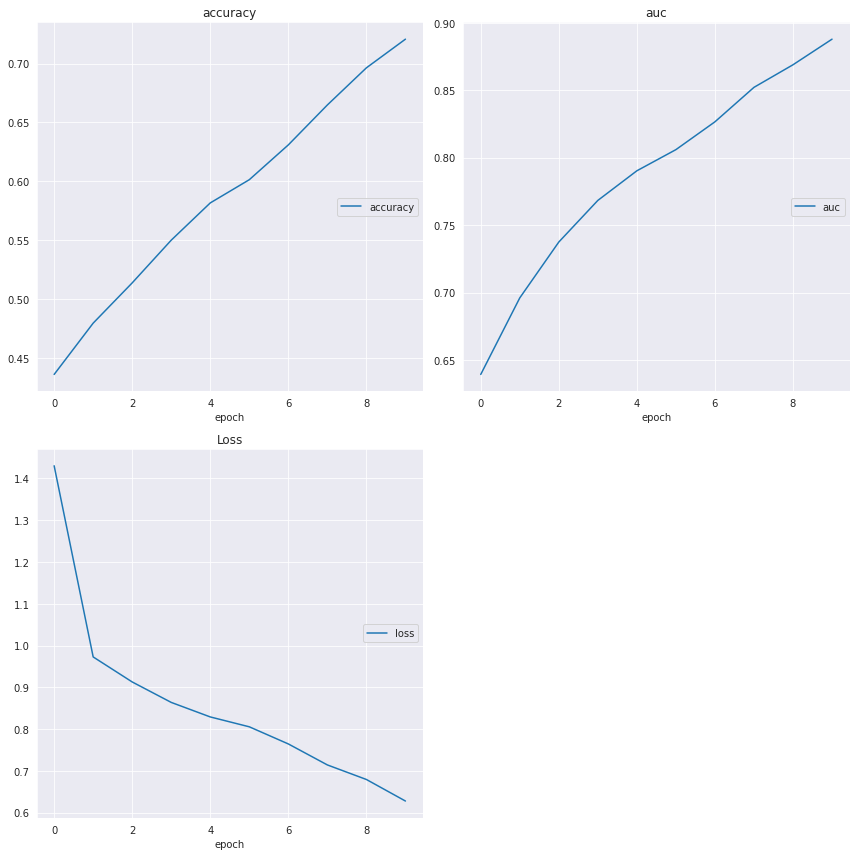

accuracy
	accuracy         	 (min:    0.436, max:    0.721, cur:    0.721)
auc
	auc              	 (min:    0.639, max:    0.888, cur:    0.888)
Loss
	loss             	 (min:    0.628, max:    1.430, cur:    0.628)


In [19]:
c1=PlotLossesKeras()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history=model.fit(x_train,y_train,epochs=10,callbacks=[c1,c3],batch_size=16)

In [20]:
model.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)

191/191 [==============================] - 1s 5ms/step - loss: 0.9500 - accuracy: 0.5690 - auc: 0.7589


[0.9499622583389282, 0.5690335035324097, 0.758851945400238]

In [21]:
print("Performance Report:")
y_pred21=model.predict_classes(x_test)
y_test21=[np.argmax(x) for x in y_test]
y_pred_prb21=model.predict_proba(x_test)
target=["G","F","D"]
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test21, y_pred21),4))
print('Precision score is :', np.round(metrics.precision_score(y_test21, y_pred21, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test21,y_pred21, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test21, y_pred21, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test21, y_pred_prb21,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test21, y_pred21),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test21, y_pred21,target_names=target))

Performance Report:
Accuracy score is : 0.5808
Precision score is : 0.6497
Recall score is : 0.5808
F1 Score is : 0.5666
ROC AUC Score is : 0.7709
Cohen Kappa Score: 0.374
		Classification Report:
               precision    recall  f1-score   support

           G       0.61      0.74      0.67       392
           F       0.84      0.33      0.47       461
           D       0.49      0.70      0.58       452

    accuracy                           0.58      1305
   macro avg       0.65      0.59      0.57      1305
weighted avg       0.65      0.58      0.57      1305



# 4 Layered CNN

In [22]:

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(32,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    
model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    
model.add(Conv2D(32,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(nClasses, activation='softmax'))


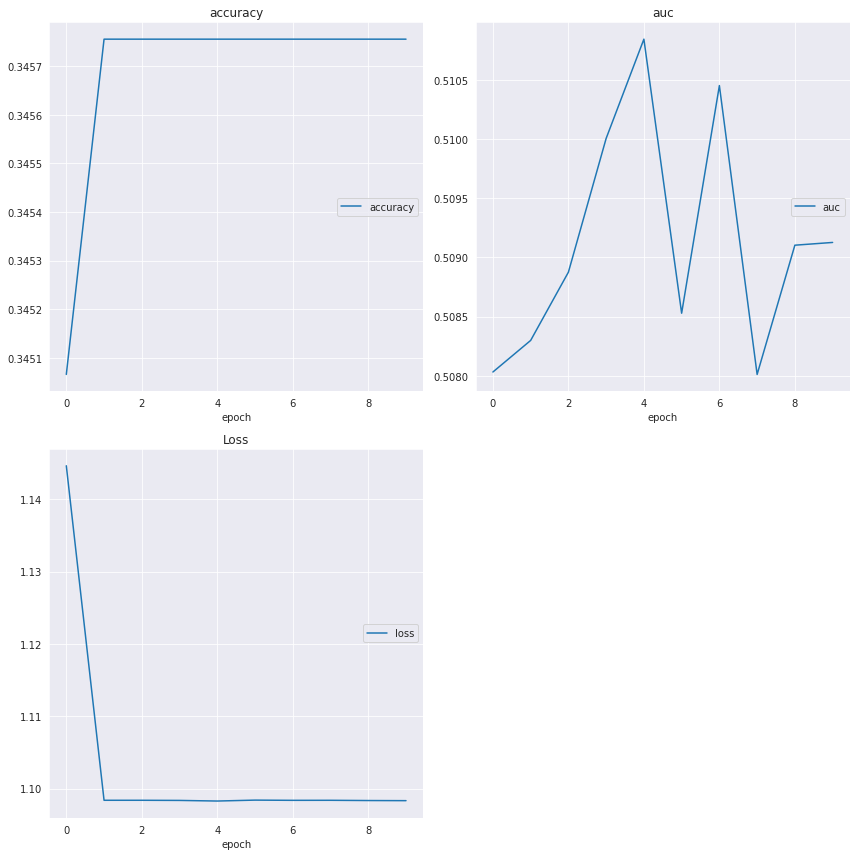

accuracy
	accuracy         	 (min:    0.345, max:    0.346, cur:    0.346)
auc
	auc              	 (min:    0.508, max:    0.511, cur:    0.509)
Loss
	loss             	 (min:    1.098, max:    1.145, cur:    1.098)


In [23]:
c1=PlotLossesKeras()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history=model.fit(x_train,y_train,epochs=10,callbacks=[c1,c3],batch_size=16)

In [24]:
model.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)

191/191 [==============================] - 1s 6ms/step - loss: 1.0975 - accuracy: 0.3524 - auc: 0.5201


[1.0975368022918701, 0.3523997366428375, 0.5200526118278503]

In [25]:
print("Performance Report:")
y_pred2=model.predict_classes(x_test)
y_test2=[np.argmax(x) for x in y_test]
y_pred_prb2=model.predict_proba(x_test)
target=["G","F","D"]
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test2, y_pred2),4))
print('Precision score is :', np.round(metrics.precision_score(y_test2, y_pred2, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test2,y_pred2, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test2, y_pred2, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test2, y_pred_prb2,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test2, y_pred2),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test2, y_pred2,target_names=target))

Performance Report:
Accuracy score is : 0.3533
Precision score is : 0.1248
Recall score is : 0.3533
F1 Score is : 0.1844
ROC AUC Score is : 0.5
Cohen Kappa Score: 0.0
		Classification Report:
               precision    recall  f1-score   support

           G       0.00      0.00      0.00       392
           F       0.35      1.00      0.52       461
           D       0.00      0.00      0.00       452

    accuracy                           0.35      1305
   macro avg       0.12      0.33      0.17      1305
weighted avg       0.12      0.35      0.18      1305



# 5 Layered CNN

In [18]:

model = Sequential()

model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(32,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    
model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    
model.add(Conv2D(128,(3,3),padding='same'))
model.add(Conv2D(128,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(nClasses, activation='softmax'))


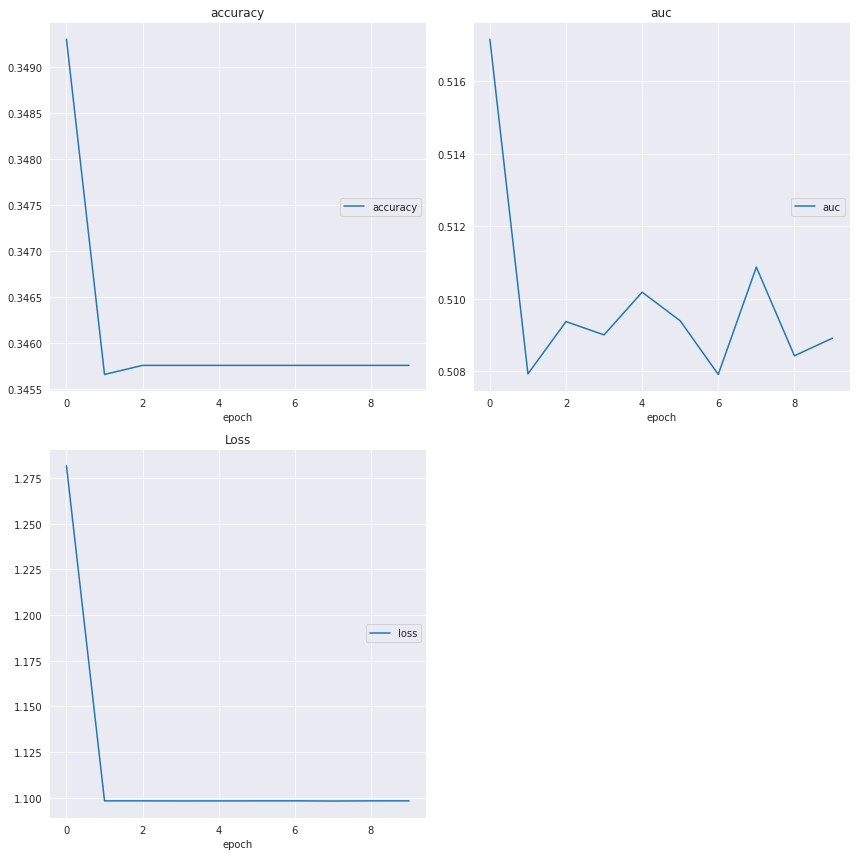

accuracy
	accuracy         	 (min:    0.346, max:    0.349, cur:    0.346)
auc
	auc              	 (min:    0.508, max:    0.517, cur:    0.509)
Loss
	loss             	 (min:    1.098, max:    1.282, cur:    1.098)


In [19]:
c1=PlotLossesKeras()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history=model.fit(x_train,y_train,epochs=10,callbacks=[c1,c3],batch_size=16)

In [20]:
model.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)

191/191 [==============================] - 2s 7ms/step - loss: 1.0977 - accuracy: 0.3524 - auc: 0.5201


[1.0976885557174683, 0.3523997366428375, 0.5200525522232056]

In [21]:
print("Performance Report:")
y_pred31=model.predict_classes(x_test)
y_test31=[np.argmax(x) for x in y_test]
y_pred_prb31=model.predict_proba(x_test)
target=["G","F","D"]
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test31, y_pred31),4))
print('Precision score is :', np.round(metrics.precision_score(y_test31, y_pred31, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test31,y_pred31, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test31, y_pred31, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test31, y_pred_prb31,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test31, y_pred31),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test31, y_pred31,target_names=target))

Performance Report:
Accuracy score is : 0.3533
Precision score is : 0.1248
Recall score is : 0.3533
F1 Score is : 0.1844
ROC AUC Score is : 0.5
Cohen Kappa Score: 0.0
		Classification Report:
               precision    recall  f1-score   support

           G       0.00      0.00      0.00       392
           F       0.35      1.00      0.52       461
           D       0.00      0.00      0.00       452

    accuracy                           0.35      1305
   macro avg       0.12      0.33      0.17      1305
weighted avg       0.12      0.35      0.18      1305



# 6 Layered CNN

In [18]:


model = Sequential()
    
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    
model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    
model.add(Conv2D(128,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))
    
model.add(Conv2D(64,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model.add(Conv2D(32,(3,3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding = 'same'))

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(nClasses, activation='softmax'))
    

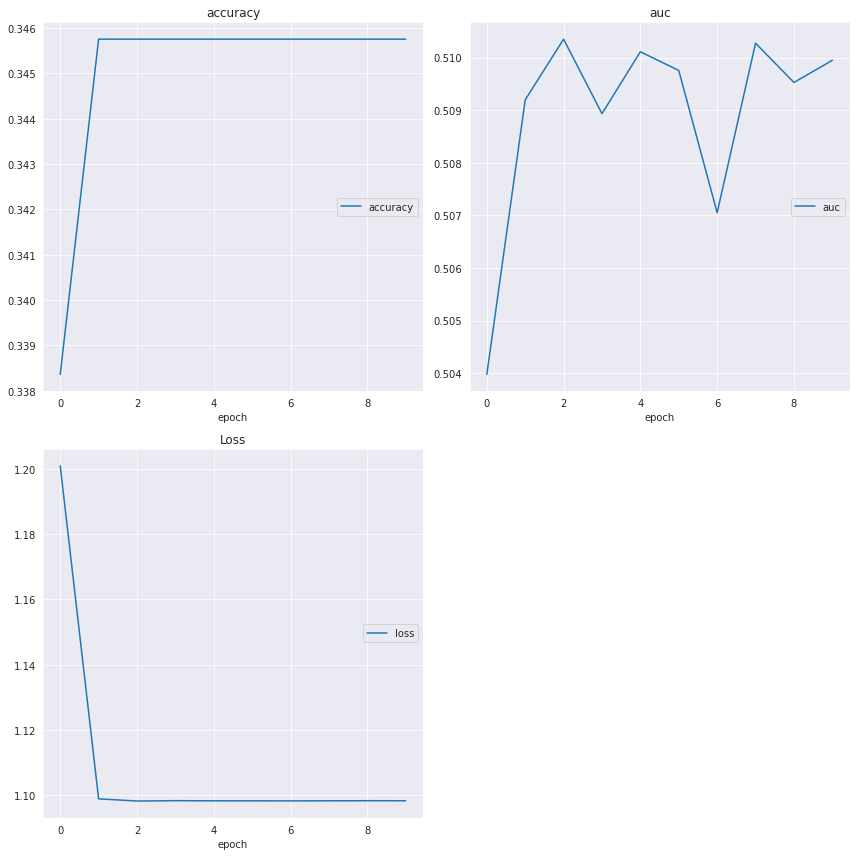

accuracy
	accuracy         	 (min:    0.338, max:    0.346, cur:    0.346)
auc
	auc              	 (min:    0.504, max:    0.510, cur:    0.510)
Loss
	loss             	 (min:    1.098, max:    1.201, cur:    1.098)


In [19]:
c1=PlotLossesKeras()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
history=model.fit(x_train,y_train,epochs=10,callbacks=[c1,c3],batch_size=16)

In [20]:
model.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)

191/191 [==============================] - 1s 5ms/step - loss: 1.0977 - accuracy: 0.3524 - auc: 0.5201


[1.0977227687835693, 0.3523997366428375, 0.5200525522232056]

In [21]:
print("Performance Report:")
y_pred3=model.predict_classes(x_test)
y_test3=[np.argmax(x) for x in y_test]
y_pred_prb3=model.predict_proba(x_test)
target=["G","F","D"]
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test3, y_pred3),4))
print('Precision score is :', np.round(metrics.precision_score(y_test3, y_pred3, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test3,y_pred3, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test3, y_pred3, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test3, y_pred_prb3,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test31, y_pred31),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test3, y_pred3,target_names=target))

Performance Report:
Accuracy score is : 0.3533
Precision score is : 0.1248
Recall score is : 0.3533
F1 Score is : 0.1844
ROC AUC Score is : 0.5
Cohen Kappa Score: 0.0
		Classification Report:
               precision    recall  f1-score   support

           G       0.00      0.00      0.00       392
           F       0.35      1.00      0.52       461
           D       0.00      0.00      0.00       452

    accuracy                           0.35      1305
   macro avg       0.12      0.33      0.17      1305
weighted avg       0.12      0.35      0.18      1305



# 7 Layered CNN

In [22]:


model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nClasses, activation='softmax'))
    

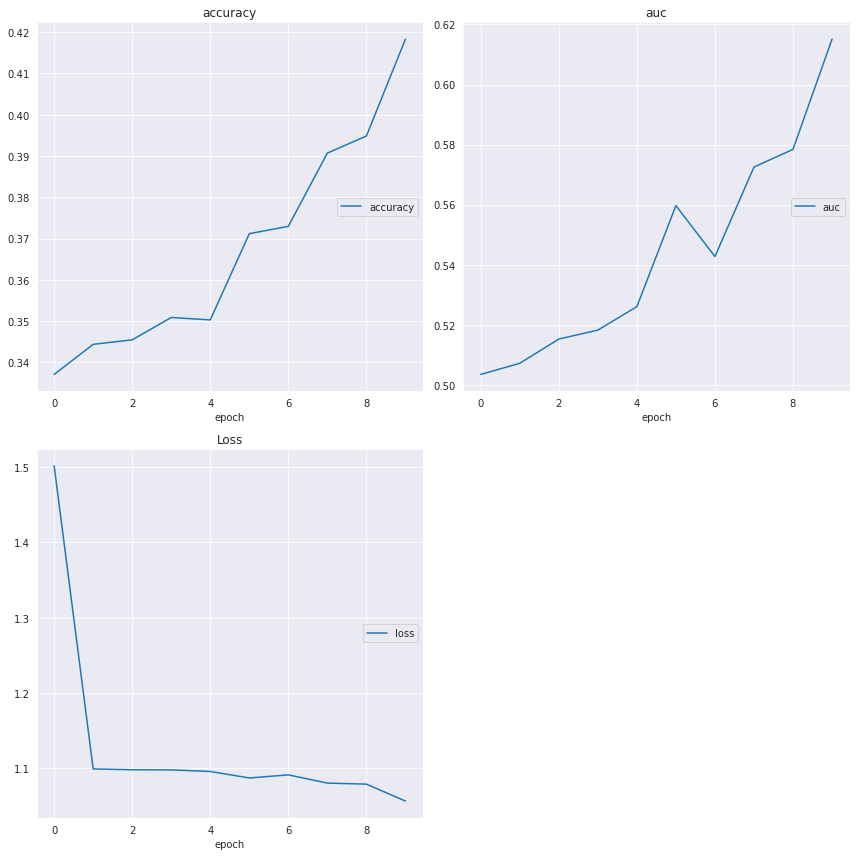

accuracy
	accuracy         	 (min:    0.337, max:    0.418, cur:    0.418)
auc
	auc              	 (min:    0.503, max:    0.615, cur:    0.615)
Loss
	loss             	 (min:    1.057, max:    1.502, cur:    1.057)


In [23]:
c1=PlotLossesKeras()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
model.fit(x_train,y_train,epochs=10,callbacks=[c1,c3],batch_size=16)

In [24]:
model.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)

191/191 [==============================] - 2s 7ms/step - loss: 1.0331 - accuracy: 0.4402 - auc: 0.6436


[1.033149242401123, 0.44017094373703003, 0.6436081528663635]

In [25]:
print("Performance Report:")
y_pred41=model.predict_classes(x_test)
y_test41=[np.argmax(x) for x in y_test]
y_pred_prb41=model.predict_proba(x_test)
target=["G","F","D"]
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test41, y_pred41),4))
print('Precision score is :', np.round(metrics.precision_score(y_test41, y_pred41, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test41,y_pred41, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test41, y_pred41, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test41, y_pred_prb41,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test41, y_pred41),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test41, y_pred41,target_names=target))

Performance Report:
Accuracy score is : 0.41
Precision score is : 0.3959
Recall score is : 0.41
F1 Score is : 0.3242
ROC AUC Score is : 0.632
Cohen Kappa Score: 0.1083
		Classification Report:
               precision    recall  f1-score   support

           G       0.49      0.46      0.47       392
           F       0.38      0.77      0.51       461
           D       0.33      0.00      0.01       452

    accuracy                           0.41      1305
   macro avg       0.40      0.41      0.33      1305
weighted avg       0.40      0.41      0.32      1305



# 8 Layered CNN

In [14]:


model = Sequential()

model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
    
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
    

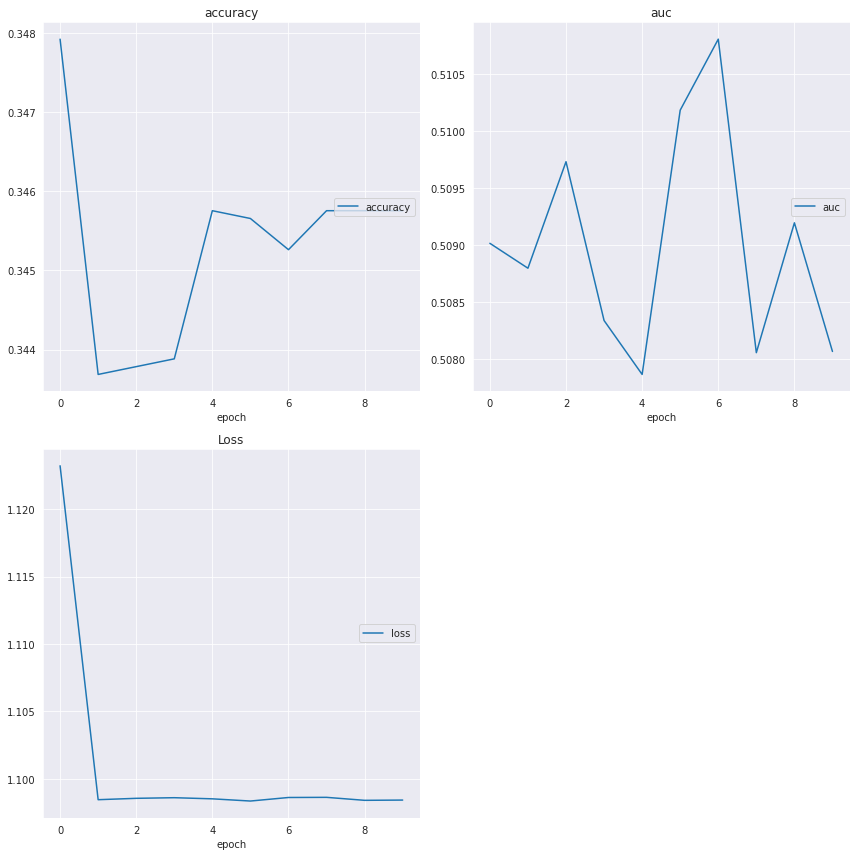

accuracy
	accuracy         	 (min:    0.344, max:    0.348, cur:    0.346)
auc
	auc              	 (min:    0.508, max:    0.511, cur:    0.508)
Loss
	loss             	 (min:    1.098, max:    1.123, cur:    1.098)


In [15]:
c1=PlotLossesKeras()
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy','AUC'])
model.fit(x_train,y_train,epochs=10,callbacks=[c1,c3],batch_size=16)

In [16]:
model.evaluate(x_val,y_val,callbacks=[c2,c3],batch_size=16)

191/191 [==============================] - 3s 11ms/step - loss: 1.0976 - accuracy: 0.3524 - auc: 0.5201


[1.0975887775421143, 0.3523997366428375, 0.5200526118278503]

In [17]:
print("Performance Report:")
y_pred4=model.predict_classes(x_test)
y_test4=[np.argmax(x) for x in y_test]
y_pred_prb4=model.predict_proba(x_test)
target=["G","F","D"]
from sklearn import metrics
print('Accuracy score is :', np.round(metrics.accuracy_score(y_test4, y_pred4),4))
print('Precision score is :', np.round(metrics.precision_score(y_test4, y_pred4, average='weighted'),4))
print('Recall score is :', np.round(metrics.recall_score(y_test4,y_pred4, average='weighted'),4))
print('F1 Score is :', np.round(metrics.f1_score(y_test4, y_pred4, average='weighted'),4))
print('ROC AUC Score is :', np.round(metrics.roc_auc_score(y_test4, y_pred_prb4,multi_class='ovo', average='weighted'),4))
print('Cohen Kappa Score:', np.round(metrics.cohen_kappa_score(y_test4, y_pred4),4))
print('\t\tClassification Report:\n', metrics.classification_report(y_test4, y_pred4,target_names=target))

Performance Report:
Accuracy score is : 0.3533
Precision score is : 0.1248
Recall score is : 0.3533
F1 Score is : 0.1844
ROC AUC Score is : 0.5
Cohen Kappa Score: 0.0
		Classification Report:
               precision    recall  f1-score   support

           G       0.00      0.00      0.00       392
           F       0.35      1.00      0.52       461
           D       0.00      0.00      0.00       452

    accuracy                           0.35      1305
   macro avg       0.12      0.33      0.17      1305
weighted avg       0.12      0.35      0.18      1305



# References and other implementations
#### https://www.kaggle.com/aayushkandpal/inceptionresnetv2-breastcancer-identification-gdf
#### https://www.kaggle.com/aayushkandpal/densenet201-breast-cancer-identification-gdf
#### https://www.kaggle.com/aayushkandpal/vgg-19-breast-cancer-identification-gdf
#### https://www.kaggle.com/aayushkandpal/mobilenet-breast-cancer-identification-gdf
#### https://www.kaggle.com/aayushkandpal/efficientnetb7-breast-cancer-identification-gdf
#### https://www.kaggle.com/aayushkandpal/xceptionnet-breast-cancer-identification-gdf
#### https://www.kaggle.com/aayushkandpal/resnet50-breast-cancer-identification-gdf
#### https://www.kaggle.com/meryemsafa/bccnnkfold
#### https://www.kaggle.com/vstein/pretrained-mobilenetv2-image-filter-on-mammogr
#### https://www.kaggle.com/valeriamoonlight/inceptionv3-for-mammography-classification
#### https://www.kaggle.com/rajaatif/mias-mammogram
#### https://www.kaggle.com/kmader/high-res-mobilenet-for-mammography
#### https://www.kaggle.com/aditi02/breastcancer-cnn-mias
